## Diplomski rad - Klasificiranje LEGO kocaka koristeći neuronske mreže

Rad se izvodi koristeći PlaidML za AMD GPU preko Keras-a

In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Promijene vezane za PlaidML se mogu izvesti sa pokretanjem `plaidml-setup` u powershell-u

Sve sljedece linije ce se spominjati na Engleskom jeziku zbog jednostavnosti i istoznacnosti sa programskim ködom na engleskom jeziku

In [2]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import cv2

Using plaidml.keras.backend backend.


Now let's explore some of the data, for starters we will use the following Kaggle dataset: [lego-brick-images](https://www.kaggle.com/joosthazelzet/lego-brick-images)

It's a fairly simple dataset containing renders of some LEGO pieces

In [3]:
os.listdir("../../LEGO_brick_images_v1")

['11214 Bush 3M friction with Cross axle',
 '18651 Cross Axle 2M with Snap friction',
 '2357 Brick corner 1x2x2',
 '3003 Brick 2x2',
 '3004 Brick 1x2',
 '3005 Brick 1x1',
 '3022 Plate 2x2',
 '3023 Plate 1x2',
 '3024 Plate 1x1',
 '3040 Roof Tile 1x2x45deg',
 '3069 Flat Tile 1x2',
 '32123 half Bush',
 '3673 Peg 2M',
 '3713 Bush for Cross Axle',
 '3794 Plate 1X2 with 1 Knob',
 '6632 Technic Lever 3M']

The first numbers denote the brick model, after that is it's name, size and possible modifications

In [4]:
os.listdir("../../LEGO_brick_images_v1/3003 Brick 2x2/")[:10]

['0001.png',
 '0002.png',
 '0003.png',
 '0004.png',
 '0005.png',
 '0006.png',
 '0007.png',
 '0008.png',
 '0009.png',
 '0010.png']

We can see that the folder are filled with individual .png files, these are loadable in Keras.

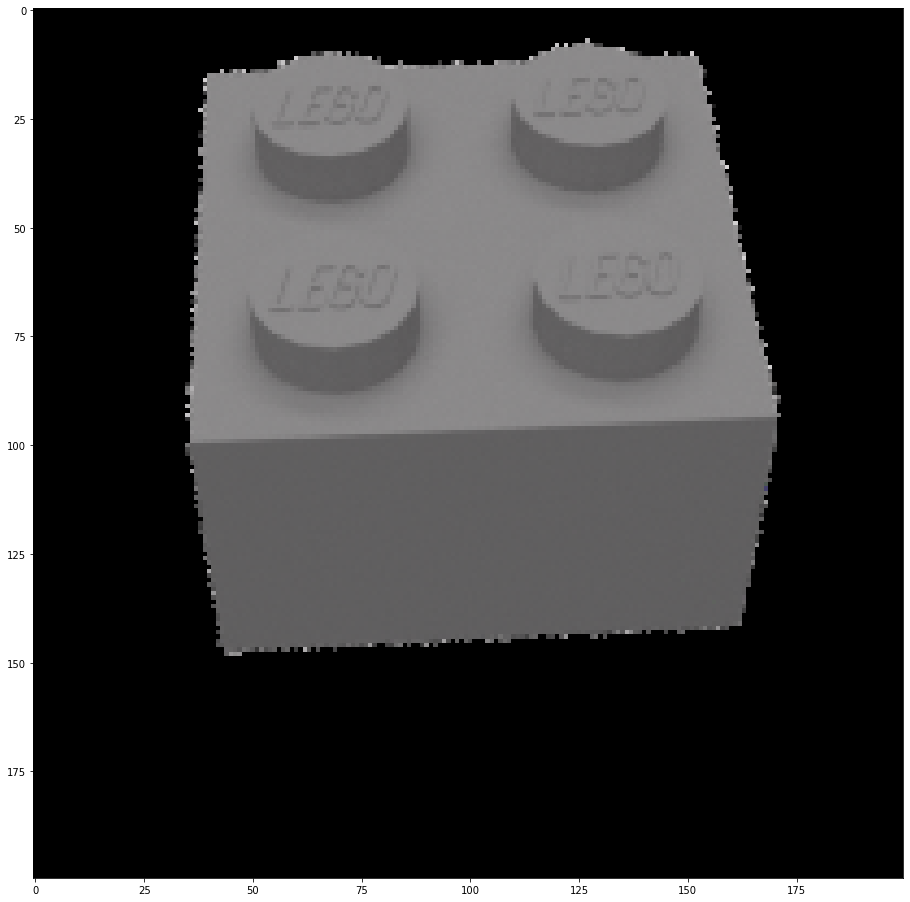

In [5]:
image_path = "../../LEGO_brick_images_v1/3003 Brick 2x2/0002.png"
image = cv2.imread(image_path)
plt.figure(figsize=(16,16))
plt.imshow(image)

In [6]:
image.shape

(200, 200, 3)

To try to load the data into Keras, we must first create a subset for training and validation

In [7]:
dataset_path = "../../LEGO_brick_images_v1/"
dataset_output = "./output"

In [8]:
#if you want you can run this once, but some randomness can be good
import splitfolders
splitfolders.ratio(dataset_path, output=dataset_output, ratio=(.7, .3))

os.listdir(dataset_output)

['train', 'val']

In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2
)
validation_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(os.path.join(dataset_output,'train'), target_size=(200,200), shuffle=True, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory(os.path.join(dataset_output, 'val'), target_size=(200,200), shuffle=True, class_mode='categorical')


print(len(train_generator.class_indices))

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Anto\anaconda3\envs\lego_

Now to declare a model and modify it, we can also use preexisting ones like VGG16 or ResNet but for this test we are using a simple one

In [10]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, Model

model = Sequential()
model.add(Conv2D(32, (3,3), input_shape=(200,200,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(train_generator.class_indices), activation="softmax"))

model.summary()

INFO:plaidml:Opening device "opencl_amd_ellesmere.0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
Total params: 20,074,448
Trainable params: 20,074,448
Non-trainable params: 0
___________

In [11]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau

best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto',
    restore_best_weights=True
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)


reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce,earlystop]

C:\Users\Anto\anaconda3\envs\lego_jupyter_fuckup\lib\site-packages\keras\callbacks.py:756: UserWarning: You are not using the TensorFlow backend. write_graph was set to False
  warnings.warn('You are not using the TensorFlow backend. '


In [12]:
from keras.optimizers import SGD

opt = SGD(lr=1e-3) #dobar za plitke mreže
model.compile(
    loss='categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)

history = model.fit_generator(
    train_generator, 
    steps_per_epoch  = None, 
    validation_data  = validation_generator,
    validation_steps = None,
    epochs = 100, 
    verbose = 1,
    callbacks=callbacks
)

json_model = model.to_json()

with open("./model/lego.json", "w") as json_file:
    json_file.write(json_model)

model.save_weights("./model/lego_weights.h5")

- acc: 0.3846 - val_loss: 1.4432 - val_acc: 0.6442

Epoch 00005: val_loss improved from 1.53244 to 1.44316, saving model to ./base.model
Epoch 6/100
140/140 [==============================] - 57s 409ms/step - loss: 1.7776 - acc: 0.4151 - val_loss: 1.3252 - val_acc: 0.6724

Epoch 00006: val_loss improved from 1.44316 to 1.32520, saving model to ./base.model
Epoch 7/100
140/140 [==============================] - 58s 416ms/step - loss: 1.7250 - acc: 0.4259 - val_loss: 1.2413 - val_acc: 0.6782

Epoch 00007: val_loss improved from 1.32520 to 1.24130, saving model to ./base.model
Epoch 8/100
140/140 [==============================] - 58s 414ms/step - loss: 1.6713 - acc: 0.4449 - val_loss: 1.1843 - val_acc: 0.6964

Epoch 00008: val_loss improved from 1.24130 to 1.18426, saving model to ./base.model
Epoch 9/100
140/140 [==============================] - 56s 397ms/step - loss: 1.6460 - acc: 0.4496 - val_loss: 1.1030 - val_acc: 0.7257

Epoch 00009: val_loss improved from 1.18426 to 1.10296, savi

In [13]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["acc"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_acc"], label="Validation acc")
    ax[0].legend()
    ax[1].legend()

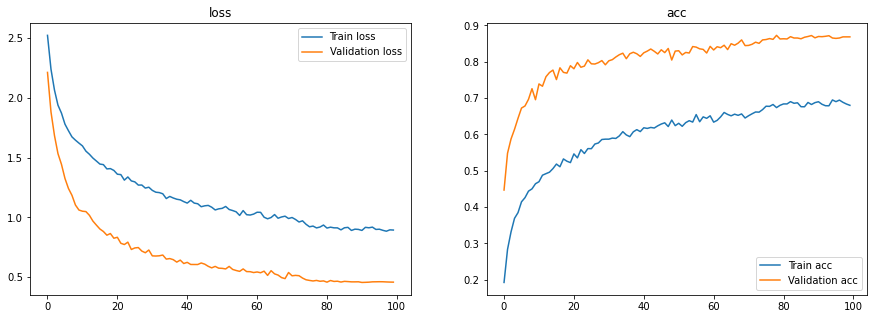

In [14]:
show_final_history(history)

In [15]:
#image_path = "../../LEGO_brick_images_v1/2357 Brick corner 1x2x2/201706171206-0001.png"
image_path = "../../LEGO_brick_images_v1/3004 Brick 1x2/0003.png"
image = cv2.imread(image_path)

from numpy import array
json_file = open("./model/lego.json", "r")
json_model = json_file.read()
json_file.close()

loaded_model = keras.models.model_from_json(json_model)
loaded_model.load_weights("./model/lego_weights.h5")

loaded_model.summary()
image = np.expand_dims(image, axis=0)
prediction = loaded_model.predict_classes(image)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 313632)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                20072512  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
Total params: 20,074,448
Trainable params: 20,074,448
Non-trainable params: 0
________________________________________________________________